In [1]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [2]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [3]:
!pip install gtts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from tensorflow import keras
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2
import natsort
from gtts import gTTS
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0]=='#':
        continue
    if line.split(" ")[1]!="err": # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

96456

In [6]:
np.random.shuffle(words_list)

In [7]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [8]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        
        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0] 
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path =  os.path.join(base_image_path, partI, 
            partI + "-" + partII,
            image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])
    
    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [9]:
print(len(train_img_paths)+ len(validation_img_paths)+len(test_img_paths))

96454


In [10]:
#train_img_paths[0]
train_labels[0]

'e04-030-04-08 ok 170 1489 1499 120 39 JJ sure'

In [11]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))


Maximum length:  21
Vocab size:  78


In [12]:
# Check some label samples.
train_labels_cleaned[:10]

['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [13]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [14]:
# Since the labels start appearing after eighth index we use that
# to retrieve the grounth-truth labels. Remember indexing starts from
# zero in Python.
start_idx = 8
train_words = [line.split(' ')[start_idx:][0].strip() for line in train_samples]
max_label_len = max([len(str(text)) for text in train_words])
print(f"Maximum label length: {max_label_len}")

padding_method = "post"
padding_token = 99
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="\n", char_level=True)
tokenizer.fit_on_texts(train_words)
tokenized_words = tokenizer.texts_to_sequences(train_words)
padded_train_words = tf.keras.preprocessing.sequence.pad_sequences(tokenized_words,
                                                        maxlen=max_label_len,
                                                        padding=padding_method,
                                                        value=padding_token)

# Maximum sequence length is 4, hence a word is padded to that length.
print(f"Integer representation of a word: {padded_train_words[0]}")

Maximum label length: 21
Integer representation of a word: [ 7 13  8  1 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]


In [15]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
AUTOTUNE = tf.data.AUTOTUNE

In [16]:


# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)



In [17]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image  = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
                  [pad_height_top, pad_height_bottom],
                  [pad_width_left, pad_width_right],
                  [0, 0]
                ]
        )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image



In [18]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [19]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


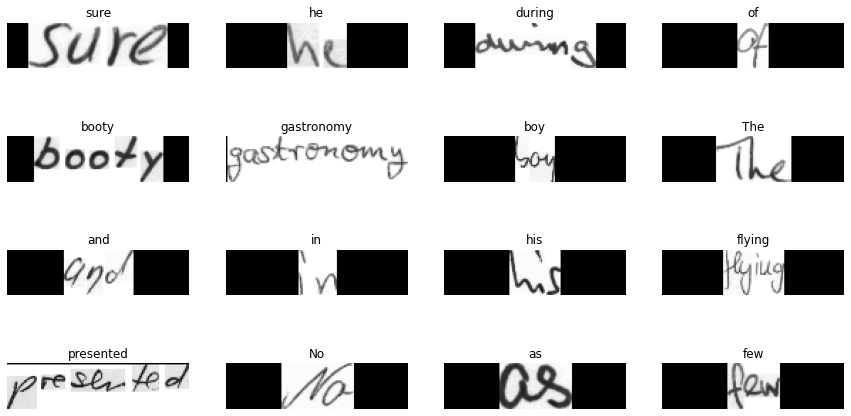

In [20]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= 99.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()


In [21]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

    
def build_model():
    # Inputs to the model
    input_img =  keras.Input(
        shape=(image_width, image_height, 1), name="image")
    labels =  keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x =  keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x =  keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x =  keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x =  keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x =  keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x =  keras.layers.Dropout(0.2)(x)

    # RNNs.
    x =  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x =  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer (the tokenizer is char-level)
    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x =  keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)
    
    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model =  keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # ab = keras.metrics.Accuracy(name='accuracy', dtype=None)
    # Compile the model and return.
    
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [42]:
epochs = 50 # To get good results this should be at least 50.

# Train the model
model = build_model()
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
)


Epoch 1/50
1357/1357 [==============================] - 133s 91ms/step - loss: 13.4047 - val_loss: 11.3817
Epoch 2/50
1357/1357 [==============================] - 70s 52ms/step - loss: 10.4086 - val_loss: 9.3676
Epoch 3/50
1357/1357 [==============================] - 85s 63ms/step - loss: 8.7537 - val_loss: 7.6413
Epoch 4/50
1357/1357 [==============================] - 83s 61ms/step - loss: 7.0956 - val_loss: 5.7217
Epoch 5/50
1357/1357 [==============================] - 69s 51ms/step - loss: 5.8216 - val_loss: 4.6626
Epoch 6/50
1357/1357 [==============================] - 67s 49ms/step - loss: 4.9984 - val_loss: 4.0319
Epoch 7/50
1357/1357 [==============================] - 67s 49ms/step - loss: 4.4527 - val_loss: 3.5914
Epoch 8/50
1357/1357 [==============================] - 63s 47ms/step - loss: 4.0390 - val_loss: 3.2639
Epoch 9/50
1357/1357 [==============================] - 66s 49ms/step - loss: 3.7210 - val_loss: 2.9736
Epoch 10/50
1357/1357 [==============================] - 64s

In [ ]:
# Ce fichier devra nous aider lors du déploiement sur streamlit
with open("model.pickle", "wb") as file:
    pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp 'model.pickle' '/content/drive/MyDrive/'

In [34]:
with open("/content/drive/MyDrive/model.pickle", "rb") as file:
    model = pickle.load(file)

In [ ]:
model.save_weights('model_text_speech.h5')

In [ ]:
# Télécharger le model
!gdown --id 1-G4YIv6fgVbJpVTknfAoVBaTMY1gZKvS

In [38]:
# Charger le model
model.load_weights('model_text_speech.h5')

In [ ]:
history.history

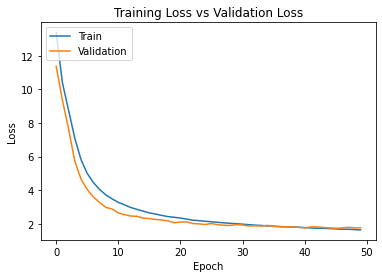

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [46]:
# Get the prediction model by extracting layers till the output layer.
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 32, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 16, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 8, 64)         0         
                                                                 
 reshape (Reshape)           (None, 32, 512)           0         
                                                                 
 dense1 (Dense)              (None, 32, 64)            3283

<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
2/2 [==============================] - 1s 11ms/step


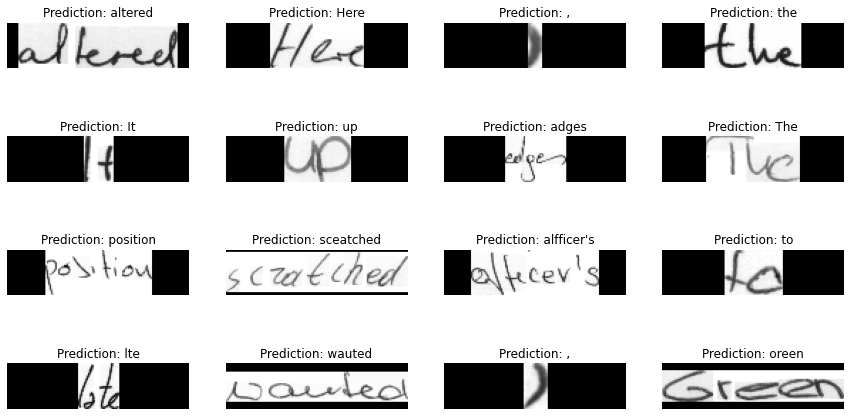

In [47]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    print(type(batch_images.shape))
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
liste_vrai = []
for data in validation_ds.take(1):
  images_val, labels_val = data["image"], data["label"]
  for i in range(len(labels_val)):
    label = labels_val[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")
    liste_vrai.append(label)


for data in validation_ds.take(1):
  image = data["image"]
  preds = prediction_model.predict(image)
  liste_new = decode_batch_predictions(preds)
 


2/2 [==============================] - 0s 10ms/step


In [ ]:
liste = []
for data in train_ds.take(1):
  lab = data["label"]
  for i in range(len(lab)):
    label = labels_val[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")
    liste.append(label)

for data in test_ds.take(1):
  lab = data["label"]
  for i in range(len(lab)):
    label = labels_val[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")
    liste.append(label)


for data in validation_ds.take(1):
  lab = data["label"]
  for i in range(len(lab)):
    label = labels_val[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")
    liste.append(label)

In [ ]:
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(liste_vrai , liste_new, labels=liste_vrai)
cm

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 2]])

In [ ]:
cm.shape

(64, 64)

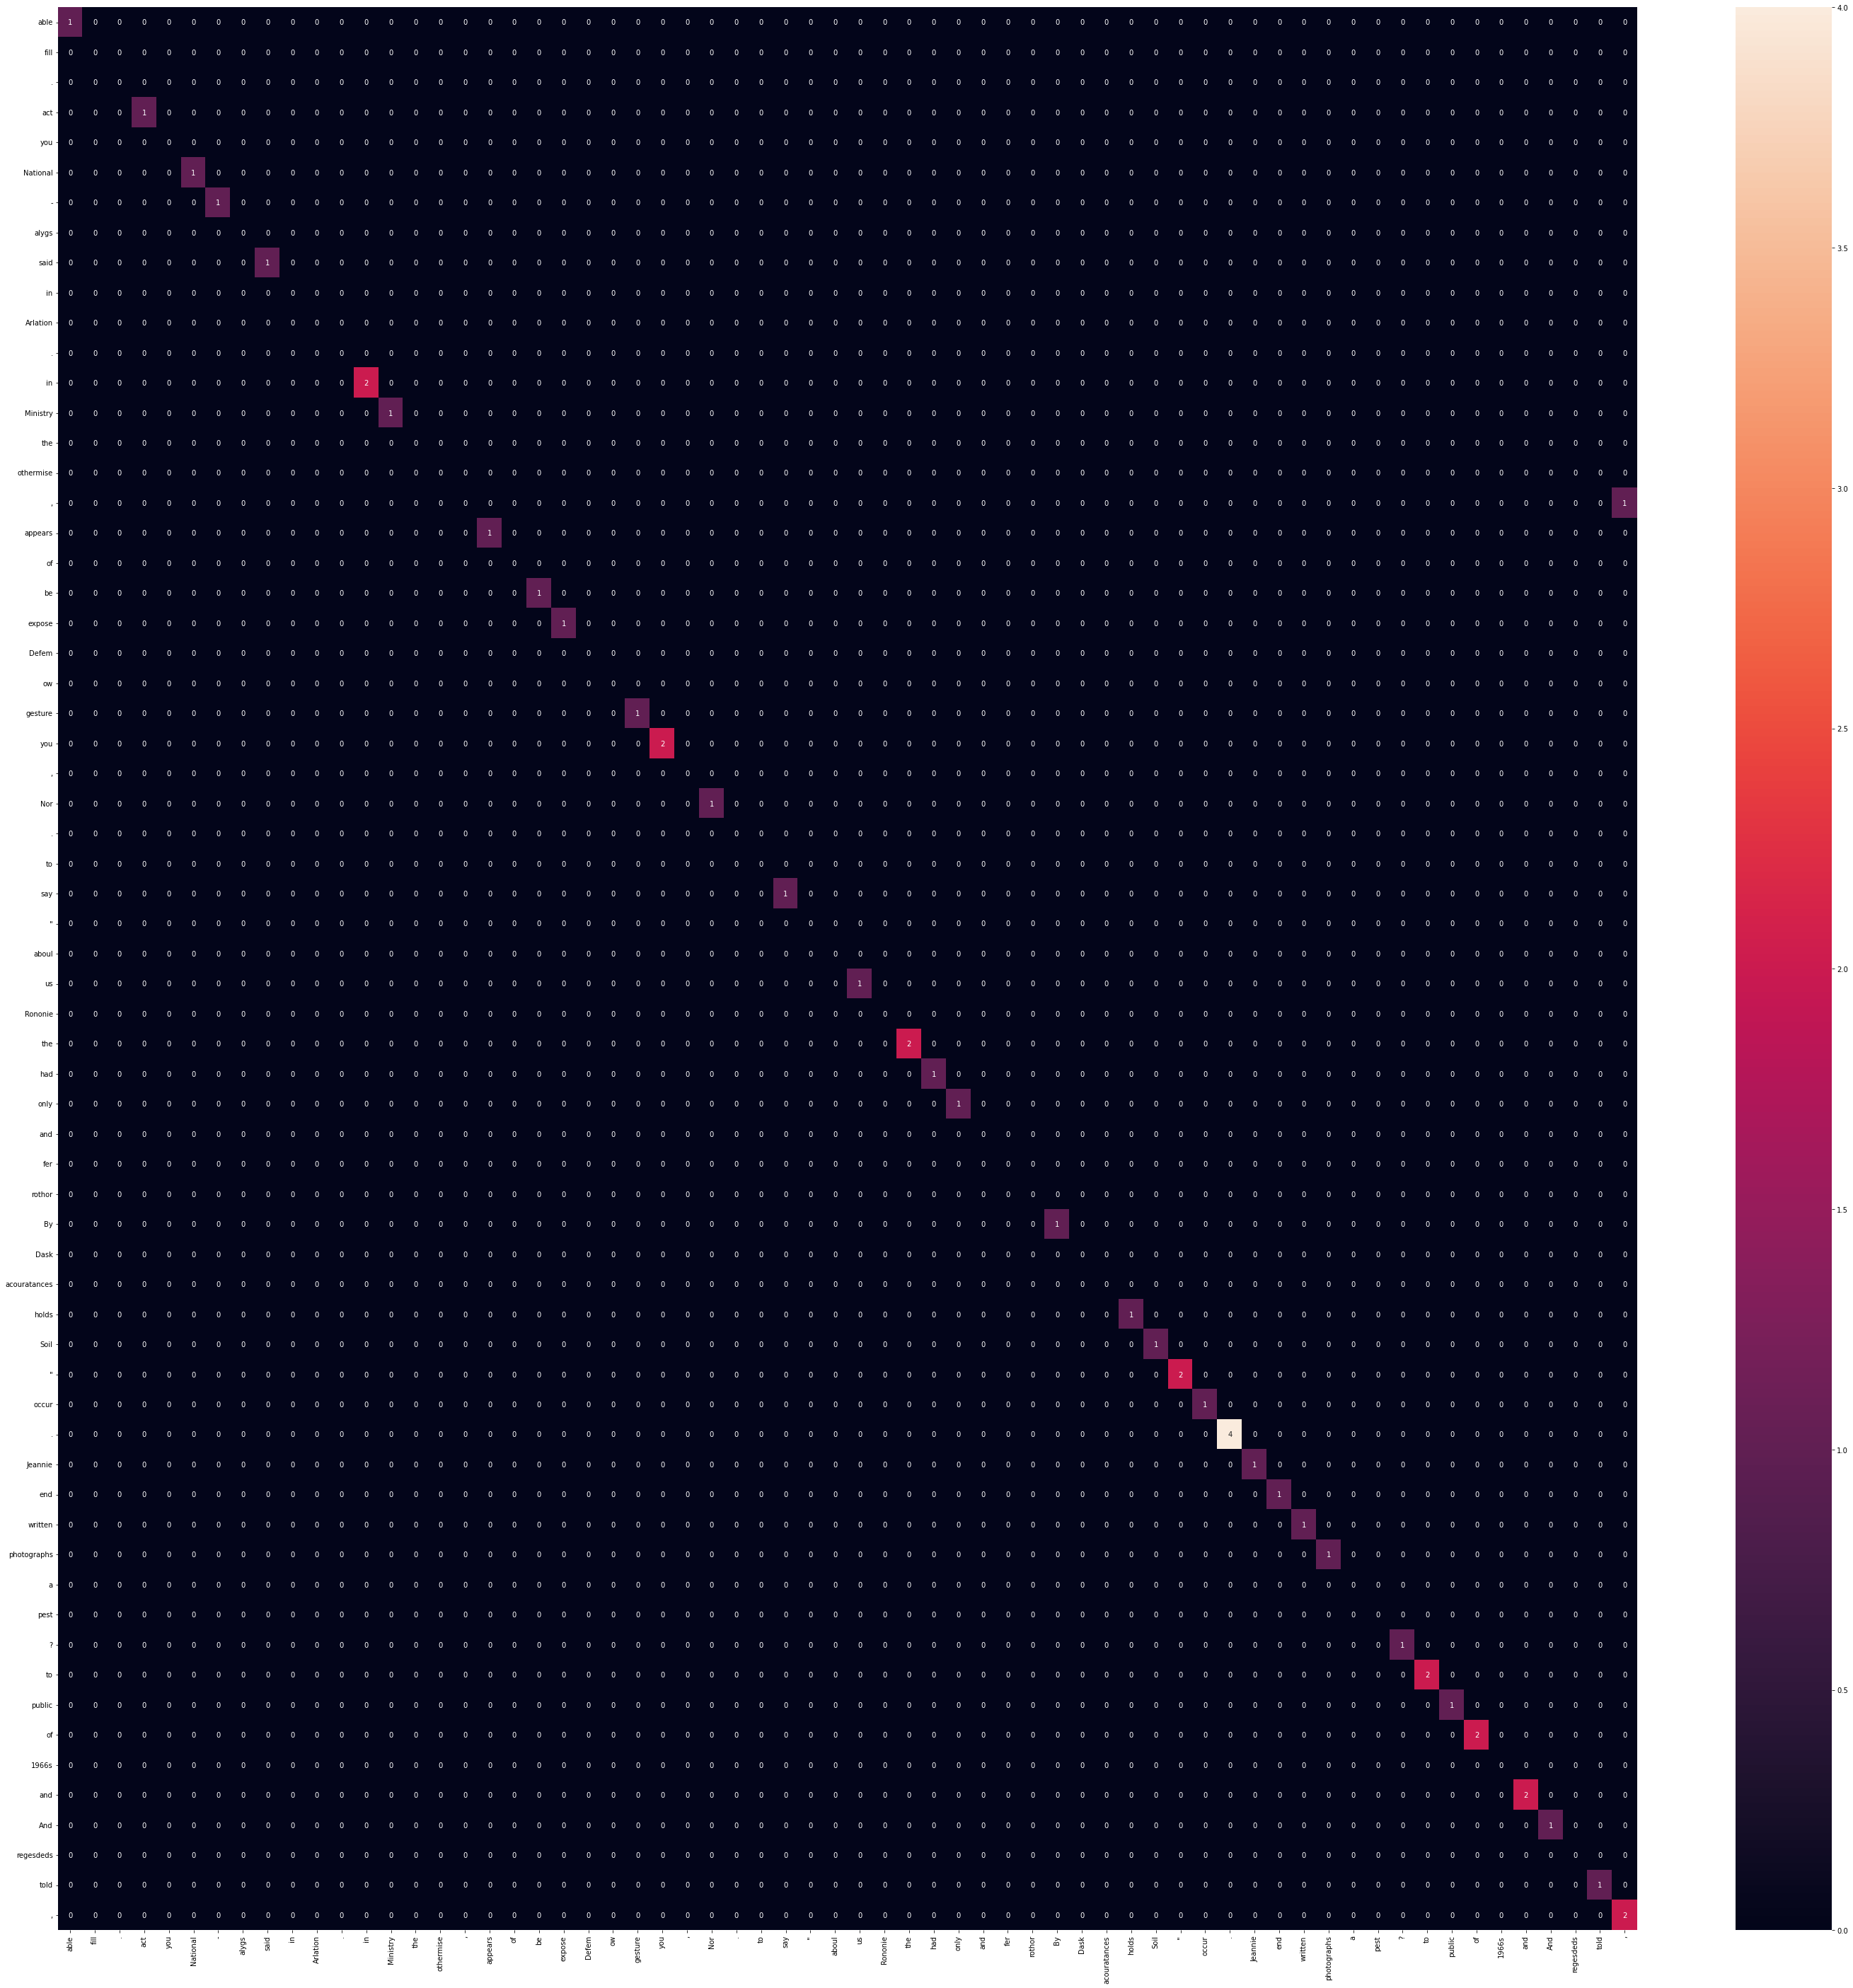

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df_cfm = pd.DataFrame(cm, index = liste_new, columns =liste_new)
plt.figure(figsize = (50, 50))
cfm_plot = sn.heatmap(df_cfm, annot=True)

In [ ]:
!gdown --id 1W6zIPM9RPycBQqSwt3k5O8xC2Nt90z5k
!unzip '/content/dataset_images_text_son.zip'
!sudo rm -r '/content/dataset_images_text_son.zip'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1W6zIPM9RPycBQqSwt3k5O8xC2Nt90z5k
To: /content/dataset_images_text_son.zip
100% 1.93M/1.93M [00:00<00:00, 174MB/s]
Archive:  /content/dataset_images_text_son.zip
   creating: dataset_images_text_son/
  inflating: dataset_images_text_son/image9.jpg  
  inflating: dataset_images_text_son/image10.jpg  
  inflating: dataset_images_text_son/image 9.jpg  
  inflating: dataset_images_text_son/image4.png  
  inflating: dataset_images_text_son/word-segmentation.JPEG  
  inflating: dataset_images_text_son/image2.png  
  inflating: dataset_images_text_son/image1.png  
  inflating: dataset_images_text_son/image3.png  
  inflating: dataset_images_text_son/image5.png  
  inflating: dataset_images_text_son/image8.png  
  inflatin

# Lecture d'une image

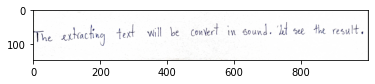

In [ ]:
img = cv2.imread('/content/dataset_images_text_son/image10.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print(type(img))
h, w, c = img.shape

if w > 1000:
    
    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)
    
    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img);

In [ ]:
def resize_image(img):
  h, w, c = img.shape
  if w > 1000:
    
    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)
    
    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
  return img


def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,175,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh
    

def dilatation_1(thresh_img):
  kernel = np.ones((3,85), np.uint8)
  dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
  return dilated

#dilation
def dilatation_2(thresh_img):
  kernel = np.ones((3,20), np.uint8)
  dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
  return dilated2

# Sauvegarde chaque image dans le fichier dossier1
def create_image_line(img):
  words_list = []
  image = resize_image(img)
  image_copy = image.copy()
  dilated = dilatation_1(thresholding(image))
  dilated2 = dilatation_2(thresholding(image))
  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
  i = 1
  for line in sorted_contours_lines:
    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]
    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    for word in sorted_contour_words:
        
        if cv2.contourArea(word) < 400:
            continue
        
        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        # cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)
  return words_list


def create_image_word(words_list, img):
  # Sauvegarde chaque image dans le fichier dossier1
  image = resize_image(img)
  image_copy = image.copy()
  i = 1
  for ninth_word in words_list:
    im = image_copy[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
    cv2.imwrite('/content/dossier1/im'+str(i)+'.jpg',im)
    i += 1

In [ ]:
# Crée un dossier vide devant contenir les images provenant des frames de nos vidéos
!mkdir dossier1

In [ ]:
!sudo rm -r dossier1

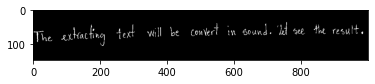

In [ ]:
img = cv2.imread('/content/dataset_images_text_son/image10.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
create_image_word(create_image_line(img), img)

In [ ]:
# Fonction permettant de lire les images dans dossier1 
def read_image_test(chemin):
  image_names = []
  label_frame = []
  image_path = []
  for dirname, _, filenames in os.walk(chemin):
    for filename in filenames:
      if os.path.join(dirname, filename)[-3:] == 'jpg':
          image = cv2.imread(os.path.join(dirname, filename))
          a, b = filename.split('.')
          # Met le nom du fichier sans extension dans une liste
          label_frame.append(a)
          # Sauve chaque image dans une liste
          image_names.append(image)
          image_path.append(os.path.join(dirname, filename))
  # retourne les fichier devant servir pour la requète et leur nom
  return natsort.natsorted(image_path), np.array(image_names), natsort.natsorted(label_frame)

image_path1, image_test1, fichier_name_test1 = read_image_test('/content/dossier1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
test_image_ds1 = prepare_dataset(image_path1, fichier_name_test1)

<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
1/1 [==============================] - 1s 1s/step


InvalidArgumentError: ignored

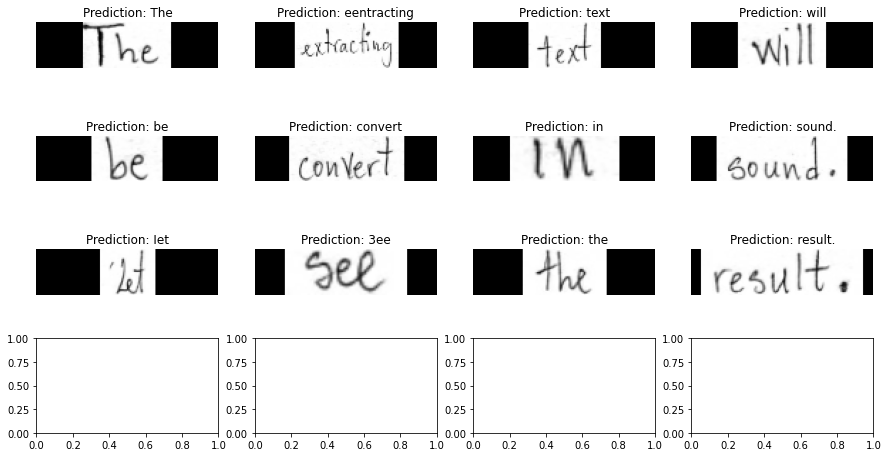

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_image_ds1.take(1):
    batch_images = batch["image"]
    print(type(batch_images.shape))
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

# Pré-traitement

# Segmentation des lignes

# Segmentation du texte

In [ ]:
print(pred_texts)

['The', 'eentracting', 'text', 'will', 'be', 'convert', 'in', 'sound.', 'Iet', '3ee', 'the', 'result.']


In [ ]:
myText = ' '.join(pred_texts)
language = 'en'

speech_result = gTTS(text = myText, lang = language, slow = False)

In [ ]:
speech_result.save('speech_result.mp3')

In [ ]:
os.system('start speech_result.mp3')

32512

In [ ]:
!python --version 

Unknown option: version
usage: ts [-r] [-i | -s] [format]
